In [1]:
##### MODELING LIBRARIES #####
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
# from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from patsy import dmatrices, dmatrix

from sklearn.metrics import accuracy_score

##### FORMATTING AND GRAPHING LIBRARIES #####
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### TIMING AND UTILITY LIBRARIES #####
import sqlalchemy as db
from datetime import datetime
import timeit
from dateutil.relativedelta import relativedelta 
import random

In [2]:
##### IMPORT PREPARED DATA #####
print('Reading pre-built dataset...')
df_load = pd.read_csv('../PJM_Weekly_Model/sample_base_data.csv', index_col = 0, parse_dates = [0])

# Drop all lag columns for us in RNN
lag_cols = [column for column in df_load.columns if 'Lag' in column]
df_load = df_load.drop(columns = lag_cols)

# Drop null rows - should only be losing daylight savings in March
dropped = df_load.shape[0] - df_load.dropna().shape[0]
print('Dropping %s null values...'%(dropped))
df_load = df_load.dropna()

# Convert date, time, holiday columns to categorical variables
for col in ['Month','WeekDay','Day','Hour','Holiday']:
    df_load[col] = df_load[col].astype('category')

Reading pre-built dataset...
Dropping 1 null values...


In [3]:
##### FINAL DATA PREPARATION #####
print("\nDefining testing and training set...") 

# Set random seed
random.seed(238)

# Use Patsy to create the one-hot encoded dummy variables with interactions 
y, X =  dmatrices('value~Light+WWP+THI+WWPSq+THISq+Month+Day+WeekDay+Hour+Holiday+WWP*Hour+WWP*Day+WWP*Holiday+WWP*Month+WWP*WeekDay+WWPSq*Hour+WWPSq*Day+WWPSq*Holiday+WWPSq*Month+WWPSq*WeekDay+THI*Hour+THI*Day+THI*Holiday+THI*Month+THI*WeekDay+THISq*Hour+THISq*Day+THISq*Holiday+THISq*Month+THISq*WeekDay+Month:Day+Hour:Day+Month:Holiday+Month:WeekDay+Hour:WeekDay+WeekDay:Holiday+THI:WWP',df_load,return_type='dataframe')

# Split data into training and testing data sets with two-year training sample (8760 h/yr * 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 17520 / X.shape[0], shuffle = False)

# Standardize both datasets - create fit to use on backcast dataset
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)


Defining testing and training set...


In [4]:
# Create training sequences
train_sequences = TimeseriesGenerator(X_train_ss, y_train['value'], length = 48, batch_size = 1024)

# Create test sequences
test_sequences = TimeseriesGenerator(X_test_ss, y_test['value'], length = 48, batch_size = 1024)

In [ ]:
##### RNN MODEL #####
tic = timeit.default_timer()
print("\nBuilding and training model...") 

model = Sequential()
model.add(GRU(1024, input_shape = (48,1603), return_sequences = True, activation = 'relu', ))
# model.add(GRU(1024, return_sequences = True, activation = 'relu'))
# model.add(GRU(512, return_sequences = True, activation = 'relu'))
model.add(GRU(256, return_sequences = True, activation = 'relu'))
# model.add(GRU(128, return_sequences = True, activation = 'relu'))
model.add(GRU(64, return_sequences = True, activation = 'relu'))
model.add(GRU(32, return_sequences = False, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = 'mean_absolute_percentage_error')

history = model.fit(train_sequences, validation_data = test_sequences, epochs = 10)

toc = timeit.default_timer()
print('RNN fit created in %0.2f seconds' % (toc-tic))


Building and training model...
Epoch 1/10
15/18 [========================>.....] - ETA: 16s - loss: 7847977472.0000 - mean_absolute_percentage_error: 95.5955

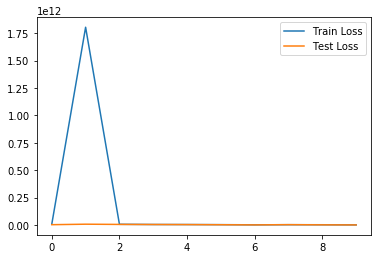

In [47]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend();

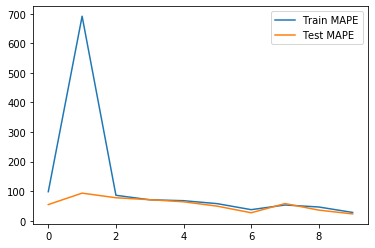

In [48]:
plt.plot(history.history['mean_absolute_percentage_error'], label = 'Train MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label = 'Test MAPE')
plt.legend();

In [49]:
y_train['predicted'] = np.append([np.NaN] * 48, model.predict(train_sequences).transpose())

C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
y_test['predicted'] = np.append([np.NaN] * 48, model.predict(test_sequences).transpose())

C:\Users\tawha\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


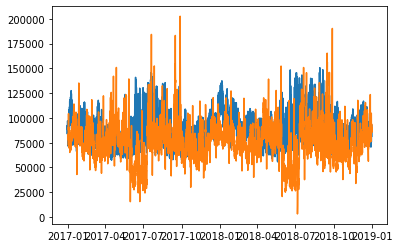

In [51]:
plt.plot(y_train)

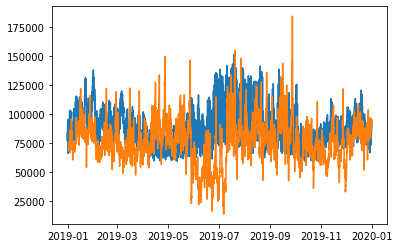

In [52]:
plt.plot(y_test)